Building a rational approximation for the expected value [xicor](https://arxiv.org/abs/1909.10140), in the case the explanitory variable x is 0/1 (an indicator) and
the dependent variable y is also 0/1 (a classification problem).

In [1]:
import numpy
import pandas

from sympy import *
init_printing(mul_symbol='times')

import seaborn as sns
import matplotlib.pyplot as plt
import xicor.xicor



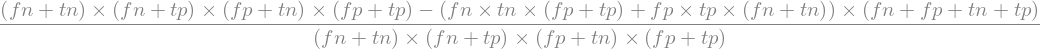

In [2]:
# estimate of expected value of xicor formula for x, y both 0/1
# https://arxiv.org/abs/1909.10140
# xicor is
# 1 - n sum(i=1,...,n-1) |r(i+1) - r(i)| / (2 sum(i=1,...,n) l(i) (n - l(i))
# n = tp + fp + tn + fn
# by the tie-breaking rules in https://CRAN.R-project.org/package=XICOR calculateXI() we have:
# ri is always tn + fp or n, so its abs differences are always 0 or tp + fn
# li is always n or tp + fn, so n - li is always 0 or tn + fp
# for the first tn + fn terms of the r(i) sum we have
# E[|r(i+1) - r(i)|] ~ |non-zero-diff| * prob_diff_is_non_zero
#                    = (tp + fn) * 2 * tn * fn / (tn + fn)**2
# for the next tp + fp terms of the r(i) sum we have
# E[|r(i+1) - r(i)|] ~ |non-zero-diff| * prob_diff_is_non_zero
#                    = (tp + fn) * 2 * tp * fp / (tp + fp)**2
# and the denominator is just 2 (tp + fp) * (tp + fp) * (tn + fn)
# putting this all together
tp, fp, tn, fn = symbols('tp fp tn fn')
xi_cor_estimate = (
    1 - (tp + fp + tn + fn) * (
        (tn + fn) * (tp + fn) * 2 * tn * fn / (tn + fn)**2
        + (tp + fp) * (tp + fn) * 2 * tp * fp / (tp + fp)**2
    ) / (2 * (tp + fn) * (tn + fp) * (tp + fn))
)

xi_cor_estimate = xi_cor_estimate.simplify()

xi_cor_estimate

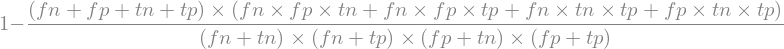

In [3]:
# neater arrangement of the formula

xicor_formula = (
    1 - (fn*fp*tn + fn*fp*tp + fn*tn*tp + fp*tn*tp) * (fn + fp + tn + tp) / ((fn + tn)*(fn + tp)*(fp + tn)*(fp + tp))
)

xicor_formula

In this form we see a lot of structure.

  * `(fn + fp + tn + tp)` is just n.
  * `(fn + tn)*(fn + tp)*(fp + tn)*(fp + tp)` is the product of all rows and columns of the confusion matrix.
  * `(fn*fp*tn + fn*fp*tp + fn*tn*tp + fp*tn*tp)` is all of the leave-1 out products of the confusion matrix entries.

In [4]:
# confirm equivalent

(xi_cor_estimate - xicor_formula).simplify()


In [5]:
# save latex
print(latex(xicor_formula, mul_symbol='times'))



1 - \frac{\left(fn + fp + tn + tp\right) \times \left(fn \times fp \times tn + fn \times fp \times tp + fn \times tn \times tp + fp \times tn \times tp\right)}{\left(fn + tn\right) \times \left(fn + tp\right) \times \left(fp + tn\right) \times \left(fp + tp\right)}


In [6]:
# define xicor as a function, so we have something to compare to
def xicor_fn(*, tp_c: int, fp_c: int, tn_c: int, fn_c: int, n_reps=20):
    """
    Define xicor as a function of observed counts.

    :param tp_c: true positive count
    :param fp_c: false positive count
    :param tn_c: true negative count
    :param fn_c: false negative count
    :return: estimated expected xicor correlation
    """
    assert tp_c >= 0
    assert fp_c >= 0
    assert tn_c >= 0
    assert fn_c >= 0
    assert tp_c + fn_c > 0  # y has positive examples
    assert tn_c + fp_c > 0  # y has negative examples
    x = [1] * tp_c + [1] * fp_c + [0] * tn_c + [0] * fn_c
    y = [1] * tp_c + [0] * fp_c + [0] * tn_c + [1] * fn_c
    evals = [xicor.xicor.Xi(x, y).correlation for rep in range(n_reps)]
    return numpy.mean(evals)


In [7]:
# wrapr our formula as a function
def xicor_rat_fn(*, tp_c: int, fp_c: int, tn_c: int, fn_c: int):
    """
    Estimate expected value of xicor using rational function.

    :param tp_c: true positive count
    :param fp_c: false positive count
    :param tn_c: true negative count
    :param fn_c: false negative count
    :return: xicor correlation
    """
    return xicor_formula.subs({tp: tp_c, tn: tn_c, fp: fp_c, fn: fn_c})

Work some examples.

In [8]:
# work some examples

float(xicor_rat_fn(tp_c=100, fp_c=10, tn_c=50, fn_c=20))

In [9]:
xicor_fn(tp_c=100, fp_c=10, tn_c=50, fn_c=20)

Plot some examples.

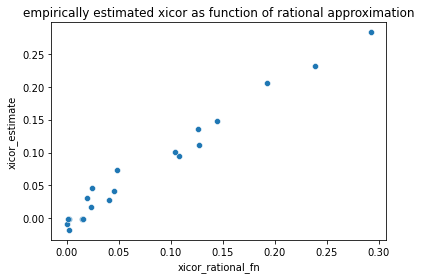

In [10]:
# plot some examples
def mk_ints():
    return numpy.random.choice(100, size=20, replace=True) + 1

examples = pandas.DataFrame({
    'tp_c': mk_ints(),
    'fp_c': mk_ints(),
    'tn_c': mk_ints(),
    'fn_c': mk_ints(),
    'xicor_estimate': 0.0,
    'xicor_rational_fn' : 0.0,
})

for i in range(examples.shape[0]):
    tp_c = examples['tp_c'].values[i]
    fp_c = examples['fp_c'].values[i]
    tn_c = examples['tn_c'].values[i]
    fn_c = examples['fn_c'].values[i]
    examples.loc[i, 'xicor_estimate'] = xicor_fn(tp_c=tp_c, fp_c=fp_c, tn_c=tn_c, fn_c=fn_c)
    examples.loc[i, 'xicor_rational_fn'] = float(xicor_rat_fn(tp_c=tp_c, fp_c=fp_c, tn_c=tn_c, fn_c=fn_c))


ax = sns.scatterplot(data=examples, x='xicor_rational_fn', y='xicor_estimate')
ax.set_title("empirically estimated xicor as function of rational approximation")
plt.show()

Check some symmetries of the rational function.

In [11]:
# check symmetries
a, b, c, d, s = symbols('a b c d s')

In [12]:
# gets independent case right (should equal 0)
xicor_rat_fn(tp_c=s*a, fp_c=s*b, tn_c=b, fn_c=a).simplify()

In [13]:
# gets perfect case right (should be 1)
xicor_rat_fn(tp_c=a, fp_c=0, tn_c=c, fn_c=0).simplify()

In [14]:

# scale invariant (should equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=s*a, fp_c=s*b, tn_c=s*c, fn_c=s*d)
).simplify()


In [15]:
# gets flipping y right (should equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=b, fp_c=a, tn_c=d, fn_c=c)
).simplify()

In [16]:
# gets flipping x right (should equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=c, fp_c=d, tn_c=a, fn_c=b)
).simplify()


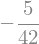

In [17]:
# is asymmetric in x and y (doesn't equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=a, fp_c=c, tn_c=b, fn_c=d)
).subs({a: 1, b: 2, c: 3, d:4})

